<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S3-Face_Recognition_Part_1/Extras/Shilpa/Face_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
# !wget -P '/content/gdrive/My Drive/e4p2/s3/' 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
# !bzip2 -dk -v '/content/gdrive/My Drive/e4p2/s3/shape_predictor_68_face_landmarks.dat.bz2'

--2020-08-13 21:35:56--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/gdrive/My Drive/e4p2/s3/shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_  73%[=============>      ]  45.19M  1.67MB/s    in 66s     

2020-08-13 21:37:02 (702 KB/s) - Connection closed at byte 47381144. Retrying.

--2020-08-13 21:37:03--  (try: 2)  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 64040097 (61M), 16658953 (16M) remaining
Saving to: ‘/content/gdrive/My Drive/e4p2/s3/shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[++++++++++++++=====>]  61.07M  6.09MB/s    in 2.6s    

2020-08-13 21:37:05 (6.09 MB/s

In [18]:
# !wget -P '/content/gdrive/My Drive/e4p2/s3/' 'http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2'
# !bzip2 -dk -v '/content/gdrive/My Drive/e4p2/s3/shape_predictor_5_face_landmarks.dat.bz2'

--2020-08-13 21:37:25--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘/content/gdrive/My Drive/e4p2/s3/shape_predictor_5_face_landmarks.dat.bz2.1’

shape_predictor_5_f 100%[===================>]   5.44M  2.97MB/s    in 1.8s    

2020-08-13 21:37:27 (2.97 MB/s) - ‘/content/gdrive/My Drive/e4p2/s3/shape_predictor_5_face_landmarks.dat.bz2.1’ saved [5706710/5706710]

  /content/gdrive/My Drive/e4p2/s3/shape_predictor_5_face_landmarks.dat.bz2: done


In [2]:
# Import modules
import sys, cv2,dlib, time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# sys.path.append('/content/gdrive/My Drive/e4p2/s3')

In [36]:
# import faceBlendCommon as fbc

In [3]:
# %%file faceBlendCommon.py

import math
# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateAffine2D for calculating the similarity transform.
  tform = cv2.estimateAffine2D(np.array([inPts]), np.array([outPts]), False)
  return tform

def normalizeImagesAndLandmarks(outSize,imIn,pointsIn):
  h, w = outSize

  # Corners of the eye in the input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36],pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2],pointsIn[0]]
  
  # Corners of the eye i  normalized image
  eyecornerDst = [(np.int(0.3*w),np.int(h/3)),(np.int(0.7*w),np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform[0], (w,h))

  # reshape pointsIn from numLandmarks x 2 to  numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn,(pointsIn.shape[0],1,pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2,tform[0])

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut,(pointsIn.shape[0],pointsIn.shape[1]))

  return imOut, pointsOut

In [4]:
path = '/content/gdrive/My Drive/e4p2/s3/'
predictor_path = path + 'shape_predictor_5_face_landmarks.dat'

In [5]:
faceDetector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(predictor_path)


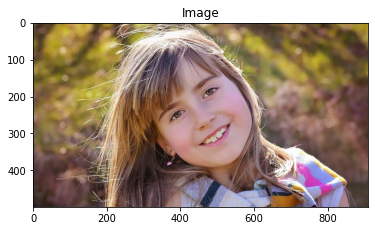

In [12]:
im = cv2.imread(path+'img1.jpg')
plt.imshow(im[:,:,::-1])
plt.title('Image')
plt.show()

In [13]:
points = getLandmarks(faceDetector,landmarkDetector,im)
print(points)
print(len(points))
points = np.array(points)

im = np.float32(im)/255.0

[(498, 178), (464, 204), (371, 264), (412, 241), (483, 279)]
5


In [14]:
def renderFace_dots(im,landmarks,color=(0,255,0),radius=3):
  for p in landmarks:
    cv2.circle(im,(p[0],p[1]),radius,color,-1)
    
img = im.copy() 
renderFace_dots(img,points)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


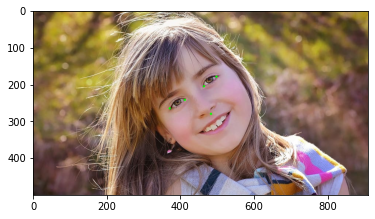

In [15]:
plt.imshow(img[:,:,::-1])

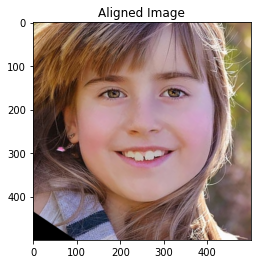

In [16]:
h = 500
w = 500

imNorm, points = normalizeImagesAndLandmarks((h,w),im,points)
imNorm = np.uint8(imNorm*255)

plt.imshow(imNorm[:,:,::-1])
plt.title('Aligned Image')
plt.show()